In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
#mpl.use('agg')
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(11)
import json
import os
from read_O3_LVK_results import *

In [2]:
precomputed_data = "stored_lnm1_q_data.npy"

if os.path.exists(precomputed_data):
    
    traces = np.load(precomputed_data,allow_pickle=True)[()]
    m1s = traces['m1s']
    qs = traces['qs']
    dR_dlnm1s_q1 = traces['dR_dlnm1s_q1']
    dR_dqs_lnm20 = traces['dR_dqs_lnm20']
    
else:

    # Load inference data
    inference_data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_lnm1_q.cdf")
    samps = inference_data.posterior.stack(draws=("chain", "draw"))

    # Also extract mass and mass ratio values
    lnm1_q_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_lnm1_q_data.npy',allow_pickle=True)[()]
    m1_values = np.exp(lnm1_q_data['all_lnm1_samples'])
    q_values = lnm1_q_data['all_q_samples']

    # For ease of plotting, coarse-grain by a factor of 50
    m1s = m1_values[::50]
    f_lnm1s = samps['f_lnm1s'][::50,:]

    R_ref = samps['R20']
    f_q1 = samps['f_qs'][-1,:]

    # Compute rate density over m1, at fixed q=1
    dR_dlnm1s_q1 = np.zeros((m1s.size,f_lnm1s.shape[1]))
    for i in range(f_lnm1s.shape[1]):
        dR_dlnm1s_q1[:,i] = R_ref[i]*f_lnm1s[:,i]*f_q1[i]

    # For ease of plotting, coarse-grain by a factor of 50
    qs = q_values[::50]
    f_qs = samps['f_qs'][::50]
    f_m20 = samps['f_lnm1s'][lnm1_q_data['ind_m20'],:]

    # Compute probability density
    dR_dqs_lnm20 = np.zeros((qs.size,f_qs.shape[1]))
    for i in range(f_qs.shape[1]):
        dR_dqs_lnm20[:,i] = R_ref[i]*f_m20[i]*f_qs[:,i]

    traces = {
        'qs':qs,
        'm1s':m1s,
        'dR_dlnm1s_q1':dR_dlnm1s_q1,
        'dR_dqs_lnm20':dR_dqs_lnm20
        }

    np.save('stored_lnm1_q_data.npy',traces)

In [14]:
lvk_m1_grid,lvk_q_grid,lvk_R_m1s_qs = get_lvk_m1_q(1000)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:56: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:61: RuntimeWarning: invalid value encountered in true_divide
  p_q_unnormed /= np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:59: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:59: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3

0.9291111111111111

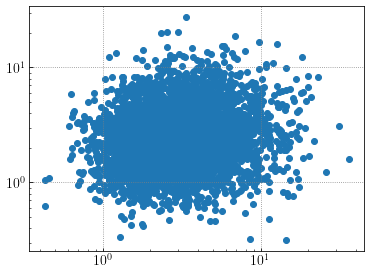

In [101]:
ind_lnm8 = np.argmin(np.abs(m1s-7.5))
ind_lnm9 = np.argmin(np.abs(m1s-9.))
ind_lnm11 = np.argmin(np.abs(m1s-11.))
ind_lnm13 = np.argmin(np.abs(m1s-13.5))

mean_R_8_to_9 = np.trapz(dR_dlnm1s_q1[ind_lnm8:ind_lnm9,:],np.log10(m1s[ind_lnm8:ind_lnm9]),axis=0)/\
    np.trapz(np.ones(np.log10(m1s[ind_lnm8:ind_lnm9]).size),np.log10(m1s[ind_lnm8:ind_lnm9]))

mean_R_9_to_11 = np.trapz(dR_dlnm1s_q1[ind_lnm9:ind_lnm11,:],np.log10(m1s[ind_lnm9:ind_lnm11]),axis=0)/\
    np.trapz(np.ones(np.log10(m1s[ind_lnm9:ind_lnm11]).size),np.log10(m1s[ind_lnm9:ind_lnm11]))

mean_R_11_to_13 = np.trapz(dR_dlnm1s_q1[ind_lnm11:ind_lnm13,:],np.log10(m1s[ind_lnm11:ind_lnm13]),axis=0)/\
    np.trapz(np.ones(np.log10(m1s[ind_lnm11:ind_lnm13]).size),np.log10(m1s[ind_lnm11:ind_lnm13]))

mid_vs_low = mean_R_9_to_11/mean_R_8_to_9
mid_vs_high = mean_R_9_to_11/mean_R_11_to_13

fig,ax = plt.subplots()
ax.scatter(mid_vs_low,mid_vs_high)
ax.set_xscale('log')
ax.set_yscale('log')

np.sum((mid_vs_low>1)*(mid_vs_high>1))/mid_vs_low.size

In [ ]:
ind_lnm8 = np.argmin(np.abs(m1s-7.5))
ind_lnm9 = np.argmin(np.abs(m1s-9.))
ind_lnm11 = np.argmin(np.abs(m1s-11.))
ind_lnm13 = np.argmin(np.abs(m1s-13.5))

mean_R_8_to_9 = np.trapz(dR_dlnm1s_q1[ind_lnm8:ind_lnm9,:],np.log10(m1s[ind_lnm8:ind_lnm9]),axis=0)/\
    np.trapz(np.ones(np.log10(m1s[ind_lnm8:ind_lnm9]).size),np.log10(m1s[ind_lnm8:ind_lnm9]))

mean_R_9_to_11 = np.trapz(dR_dlnm1s_q1[ind_lnm9:ind_lnm11,:],np.log10(m1s[ind_lnm9:ind_lnm11]),axis=0)/\
    np.trapz(np.ones(np.log10(m1s[ind_lnm9:ind_lnm11]).size),np.log10(m1s[ind_lnm9:ind_lnm11]))

mean_R_11_to_13 = np.trapz(dR_dlnm1s_q1[ind_lnm11:ind_lnm13,:],np.log10(m1s[ind_lnm11:ind_lnm13]),axis=0)/\
    np.trapz(np.ones(np.log10(m1s[ind_lnm11:ind_lnm13]).size),np.log10(m1s[ind_lnm11:ind_lnm13]))

mid_vs_low = mean_R_9_to_11/mean_R_8_to_9
mid_vs_high = mean_R_9_to_11/mean_R_11_to_13

fig,ax = plt.subplots()
ax.scatter(mid_vs_low,mid_vs_high)
ax.set_xscale('log')
ax.set_yscale('log')

np.sum((mid_vs_low>1)*(mid_vs_high>1))/mid_vs_low.size

-1.1428520713828056 -3.838402631882994 0.874


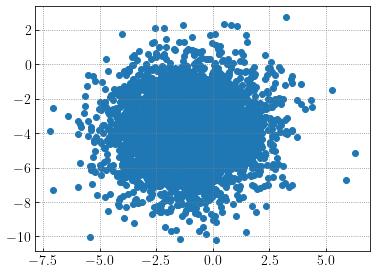

In [111]:
ind_lnm15 = np.argmin(np.abs(m1s-15.))
ind_lnm25 = np.argmin(np.abs(m1s-25.))
ind_lnm45 = np.argmin(np.abs(m1s-45.))
ind_lnm70 = np.argmin(np.abs(m1s-70.))

R_15 = dR_dlnm1s_q1[ind_lnm15,:]
R_25 = dR_dlnm1s_q1[ind_lnm25,:]
R_45 = dR_dlnm1s_q1[ind_lnm45,:]
R_70 = dR_dlnm1s_q1[ind_lnm70,:]

slope_15_to_25 = np.log10(R_25/R_15)/np.log10(25./15.)
slope_45_to_70 = np.log10(R_70/R_45)/np.log10(70./45.)

fig,ax = plt.subplots()
ax.scatter(slope_15_to_25,slope_45_to_70)
#ax.set_xscale('log')
#ax.set_yscale('log')

print(np.mean(slope_15_to_25),np.mean(slope_45_to_70),np.sum(slope_45_to_70<slope_15_to_25)/slope_15_to_25.size)

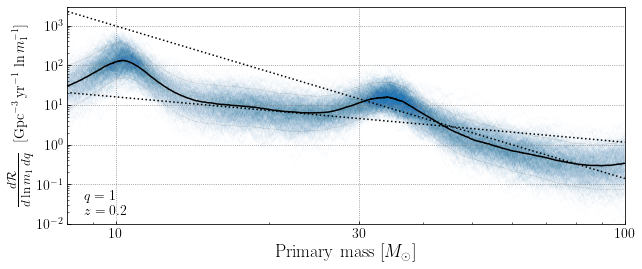

In [115]:
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(1)

#3182bd
      
for i in np.random.choice(range(dR_dlnm1s_q1.shape[1]),size=500,replace=False):                 
    ax.plot(m1s,dR_dlnm1s_q1[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(m1s,np.median(dR_dlnm1s_q1,axis=1),color='black')
ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.05,axis=1),color='grey',lw=0.15)
ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='grey',lw=0.15)

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=18)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=19)

ax.plot(m1s,10.*(m1s/15.)**(-1.14),ls=':',color='black')
ax.plot(m1s,3.*(m1s/45.)**(-3.84),ls=':',color='black')

#plt.savefig('lnm1.pdf',bbox_inches='tight',dpi=200)
plt.show()

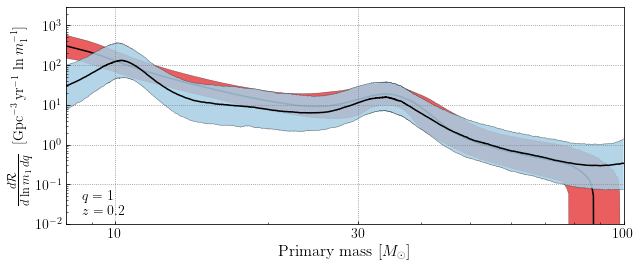

In [26]:
fig,ax = plt.subplots(figsize=(10,4))
ax.set_rasterization_zorder(1)

ax.plot(m1s,np.median(dR_dlnm1s_q1,axis=1),color='black')
ax.fill_between(m1s,np.quantile(dR_dlnm1s_q1,0.05,axis=1),np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='#a6cee3',lw=0.15,alpha=0.85)

ax.plot(lvk_m1_grid,np.median(lvk_R_m1s_qs[:,-1,:],axis=0)*lvk_m1_grid,color='black',zorder=-1)
ax.fill_between(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,
                np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.05,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(m1s,np.quantile(dR_dlnm1s_q1,0.95,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.05,axis=0)*lvk_m1_grid,color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_m1_grid,np.quantile(lvk_R_m1s_qs[:,-1,:],0.95,axis=0)*lvk_m1_grid,color='black',lw=0.5,alpha=0.5,zorder=-1)

ax.tick_params(labelsize=14)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,3e3)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.text(0.03,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.03,0.06,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=16)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

#plt.savefig('lnm1_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()

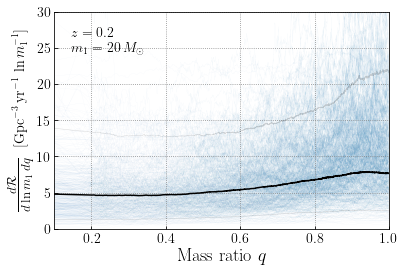

In [70]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

for i in np.random.choice(range(dR_dqs_lnm20.shape[1]),size=500,replace=False):                 
    ax.plot(qs,dR_dqs_lnm20[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(qs,np.median(dR_dqs_lnm20,axis=1),color='black')
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.5,alpha=0.15)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.5,alpha=0.15)

ax.tick_params(labelsize=14)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)

ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Mass ratio $q$',fontsize=18)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=19)

plt.savefig('q_rate.pdf',bbox_inches='tight',dpi=200)
plt.show()

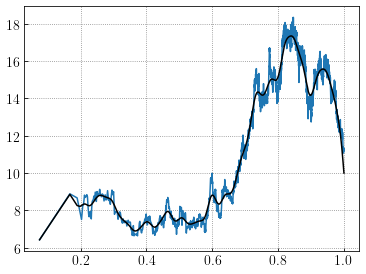

In [4]:
from scipy.ndimage import gaussian_filter

fig,ax = plt.subplots()

ax.plot(qs,dR_dqs_lnm20[:,155])

#kernel = np.exp(-np.subtract.outer(qs,qs)**2/(2.*0.01**2))
#test = kernel*dR_dqs_lnm20[:,75]

extended_qs = np.concatenate([qs,2.-qs])
kernel = np.exp(-np.subtract.outer(extended_qs,extended_qs)**2/(2.*0.01**2))
test = kernel*np.concatenate([dR_dqs_lnm20[:,155],dR_dqs_lnm20[::-1,155]])

ax.plot(qs,(np.sum(test,axis=1)/np.sum(kernel,axis=1))[:qs.size],color='black')

In [15]:
extended_qs = np.concatenate([qs,2.-qs])
kernel = np.exp(-np.subtract.outer(extended_qs,extended_qs)**2/(2.*0.01**2))

ind_q05 = np.argmin(np.abs(qs-0.5))

nDraws=1000
q_ratios = np.zeros(nDraws)
for i in range(nDraws):
    
    test = kernel*np.concatenate([dR_dqs_lnm20[:,i],dR_dqs_lnm20[::-1,i]]) 
    smoothed_rates = (np.sum(test,axis=1)/np.sum(kernel,axis=1))[:qs.size]
    q_ratios[i] = smoothed_rates[-1]/smoothed_rates[ind_q05]

In [118]:
print(np.quantile(q_ratios,0.5)-np.quantile(q_ratios,0.05),np.quantile(q_ratios,0.5),np.quantile(q_ratios,0.95)-np.quantile(q_ratios,0.5))

0.2530944003737984 1.142488628069962 1.6780643371072124


0.761


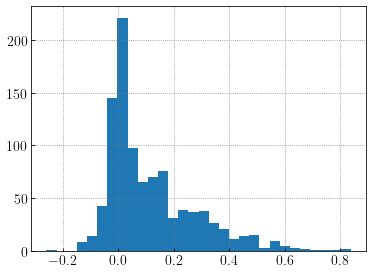

In [16]:
print(q_ratios[q_ratios>1].size*1./q_ratios.size)
plt.hist(np.log10(q_ratios),bins=30)
plt.show()

0.926


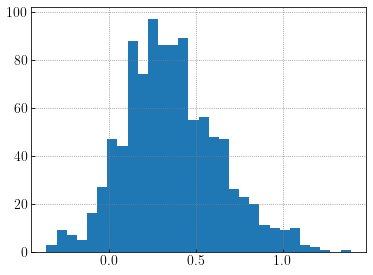

In [18]:
ind_lvk_q05 = np.argmin(np.abs(lvk_q_grid-0.5))

ind_m20 = np.argmin(np.abs(lvk_m1_grid-20.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*20.

lvk_ratio = lvk_dR_dq_lnm20[:,-1]/lvk_dR_dq_lnm20[:,ind_lvk_q05]
print(lvk_ratio[lvk_ratio>1].size*1./lvk_ratio.size)

plt.hist(np.log10(lvk_dR_dq_lnm20[:,-1]/lvk_dR_dq_lnm20[:,ind_lvk_q05]),bins=30)
plt.show()

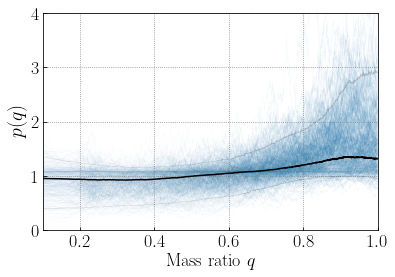

In [57]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

p_qs = dR_dqs_lnm20/np.trapz(dR_dqs_lnm20,qs,axis=0)

for i in np.random.choice(range(p_qs.shape[1]),size=500,replace=False):                 
    ax.plot(qs,p_qs[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(qs,np.median(p_qs,axis=1),color='black')
ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='black',lw=0.5,alpha=0.15)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='black',lw=0.5,alpha=0.15)

ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,4)

ax.set_xlabel('Mass ratio $q$',fontsize=18)
ax.set_ylabel(r'$p(q)$',fontsize=20)

plt.savefig('q.pdf',bbox_inches='tight',dpi=200)
plt.show()

In [100]:
print(np.log10(9./7.5),np.log10(11./9.),np.log10(13.5/11.))

0.07918124604762482 0.0871501757189002 0.08894108333678108


In [80]:
print(np.log10(28./20.),np.log10(40./28.),np.log10(55./40.))

0.146128035678238 0.1549019599857432 0.13830269816628146


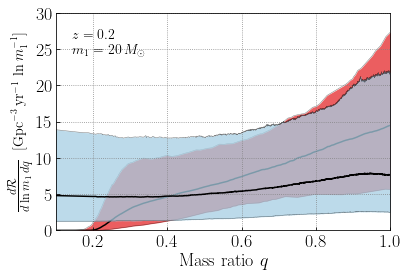

In [199]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

ax.plot(qs,np.median(dR_dqs_lnm20,axis=1),color='black')
ax.fill_between(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),
                np.quantile(dR_dqs_lnm20,0.95,axis=1),
                color='#a6cee3',lw=0.15,alpha=0.75)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-30.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*30.

ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.plot(qs,np.quantile(dR_dqs_lnm20,0.05,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(qs,np.quantile(dR_dqs_lnm20,0.95,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)

ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)

ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)

ax.set_xlabel('Mass ratio $q$',fontsize=18)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

plt.savefig('q_rate_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()

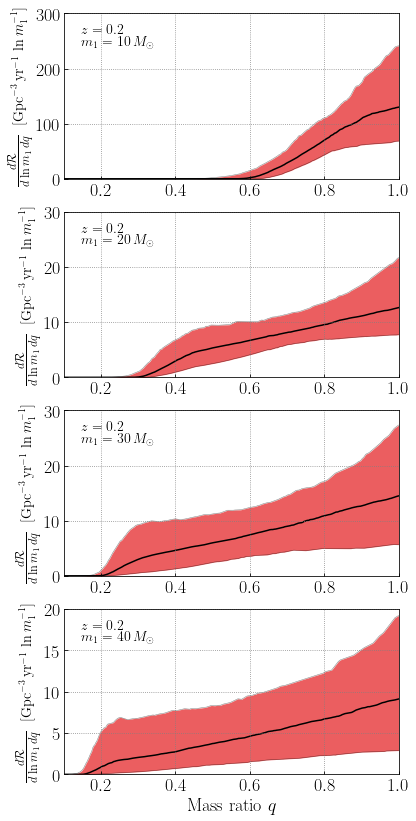

In [11]:
fig = plt.figure(figsize=(6,14))

ax = fig.add_subplot(411)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-10.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*10.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,300)
ax.text(0.05,0.83,r'$m_1=10\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

ax = fig.add_subplot(412)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-20.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*20.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)
ax.text(0.05,0.83,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

ax = fig.add_subplot(413)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-30.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*30.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,30)
ax.text(0.05,0.83,r'$m_1=30\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)

ax = fig.add_subplot(414)

ind_m20 = np.argmin(np.abs(lvk_m1_grid-40.))
lvk_dR_dq_lnm20 = lvk_R_m1s_qs[:,:,ind_m20]*40.
ax.plot(lvk_q_grid,np.median(lvk_dR_dq_lnm20,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),
                np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_dR_dq_lnm20,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.tick_params(labelsize=18)
ax.set_xlim(0.1,1)
ax.set_ylim(0,20)
ax.text(0.05,0.83,r'$m_1=40\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.text(0.05,0.90,r'$z=0.2$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=14)
ax.set_ylabel(r'$\frac{d\mathcal{R}}{d\ln m_1\,dq}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)
ax.set_xlabel('Mass ratio $q$',fontsize=18)


plt.savefig('lvk_mass_ratios.pdf',bbox_inches='tight',dpi=200)
plt.show()

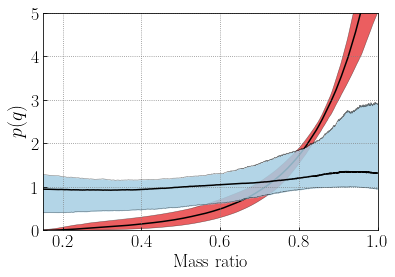

In [66]:
fig,ax = plt.subplots(figsize=(6,4))
ax.set_rasterization_zorder(1)

ax.plot(qs,np.median(p_qs,axis=1),color='black')
ax.fill_between(qs,np.quantile(p_qs,0.05,axis=1),np.quantile(p_qs,0.95,axis=1),color='#a6cee3',lw=0.15,alpha=0.85)

lvk_R_qs = np.trapz(lvk_R_m1s_qs,lvk_m1_grid,axis=2)
lvk_p_qs = np.array([lvk_R_qs[i,:]/np.trapz(lvk_R_qs[i,:],lvk_q_grid) for i in range(lvk_R_qs.shape[0])])

ax.plot(lvk_q_grid,np.median(lvk_p_qs,axis=0),color='black',zorder=-1)
ax.fill_between(lvk_q_grid,np.quantile(lvk_p_qs,0.05,axis=0),
                np.quantile(lvk_p_qs,0.95,axis=0),
                color='#e31a1c',alpha=0.7,zorder=-2,lw=0)

ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='black',lw=0.5,alpha=0.5)
ax.plot(lvk_q_grid,np.quantile(lvk_p_qs,0.05,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)
ax.plot(lvk_q_grid,np.quantile(lvk_p_qs,0.95,axis=0),color='black',lw=0.5,alpha=0.5,zorder=-1)

ax.tick_params(labelsize=18)
ax.set_xlim(0.15,1)
ax.set_ylim(0,5)

ax.set_xlabel('Mass ratio',fontsize=18)
ax.set_ylabel(r'$p(q)$',fontsize=20)

plt.savefig('q_comparison.pdf',bbox_inches='tight',dpi=200)
plt.show()